# 2 Asymptotoc local error for NN classifier

Our toy model:
- #of classes $C = 2$
- data =  (features, labels) = $(X, Y)\in([0,1]\times \{0,1\})$ 
- feature density $p(x) = 1$
- posteriors: $p(Y=0|x)= 1-x$ and $p(Y=1|x) = x$

The Gini impurity is given by: \begin{align*}
p_{\infty}(error|x) &= 1 - \sum_{k=1}^C p(Y=k|x)² \\
&= 1 - [ (1-x)^2 + x^2] \\
&= 2 (x - x²)
\end{align*}

The total error yields therefor: \begin{align*}
p_{\infty}(error) &= \int_{[0,1]} p_{\infty}(error|x) p(x) \text{d}x \\
&= 2 \int_0^1 (x - x²) \cdot 1 \text{d}x \\
&= (x² - \frac{2}{3} x³)  \mid_0^1 \\
&= \frac{1}{3}
\end{align*}


# 3 Nearest Neighbor Classification on Real Data
## 3.1 Exploring the Data

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier as knn2
import pandas as pd

In [2]:
digits = load_digits()
print ( digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print ( data.dtype )

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
float64


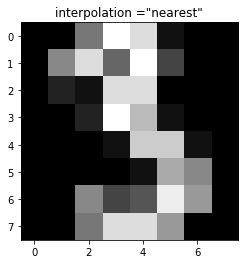

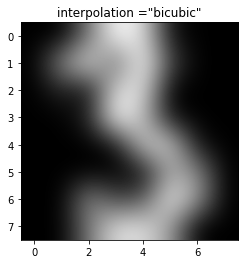

In [3]:
img = images[np.where(target==3)[0][0]]
assert 2 == len(img.shape)
plt.figure()
plt.gray()
plt.imshow(img , interpolation ="nearest") # also try interpolation =" bicubic "
plt.title('interpolation ="nearest"')
plt.show()

plt.figure()
plt.gray()
plt.imshow(img , interpolation ="bicubic") # also try interpolation =" bicubic "
plt.title('interpolation ="bicubic"')
plt.show()

In [4]:
X_all = data
y_all = target
X_train , X_test , y_train , y_test =\
model_selection.train_test_split( digits.data , digits.target , test_size = 0.4 , random_state = 0)

## 3.2 Distance function computation using loops

In [5]:
def euclidian_dist(u,v):
    # computes euclidean distance between two points
    return np.sqrt(np.sum(np.square(u-v)))

def dist_loop(training,test):
    N = len(training)
    M = len(test)
    
    dist_N = []
    dist_M = []

    for i in range(N):
        dist_M = []      
        for j in range(M):
            dist_M.append(euclidian_dist(training[i],test[j]))
        dist_N.append(dist_M)
        
    return dist_N

In [6]:
# test fct
D_loop = dist_loop(X_train,X_test)
print(len(X_train),len(X_test)) # proof dimensions
print(np.shape(D_loop))

1078 719
(1078, 719)


## 3.3 Distance function computation using vectorization

In [7]:
# def new fct
def dist_vec(training,test):
    N = len(training)
    M = len(test)
    
    # create grid with indices a and b such that all distances
    # distance = absolute ( training_a - test_b )
    # between the data points can be computed
    a,b = np.mgrid[:N,:M]
    
    # directly return distances
    return np.sqrt(np.sum(np.square(training[a]-test[b]),axis=2))

In [8]:
# test new fct
D_vec = dist_vec(X_train,X_test)

print(len(X_train),len(X_test))# proof dimensions
print(np.shape(D_vec))

1078 719
(1078, 719)


In [9]:
# compare vectorized with loop entries
print(np.where(np.abs(D_vec-D_loop)>1e-6)[0])

[]


In [10]:
# compare vectorized with loop computation time
print('dist_loop')
%timeit dist_loop(X_train,X_test)

print('dist_vec')
%timeit dist_vec(X_train,X_test)

dist_loop
12.2 s ± 511 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
dist_vec
1.64 s ± 58.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The vectorized version is signicantly faster.

## 3.4 Implement the k-nearest neighbor classier

In [11]:
# implement NN 
def k_nearest_neighbor(k,features,training_set):

    # compute distances and give indices sorted by distances
    knn = np.argsort(dist_vec(features,training_set[0]))[:,:k]
    
    # use the k entries with smallest distance,
    # take their labels and bin them,
    # the index of the most frequent bin is equal to the most frequent label
    # asign this label to the label of the feature
    labels = [np.argmax(y) for y in [np.bincount(x) for x in training_set[1][knn]]]
    
    return labels

# define error rate function
def p_err (predicted,true_label):
    return len(np.where(predicted!=true_label)[0])*len(predicted)**-1

In [12]:
# filter out indices where 3 or 9
ind_test = np.where((y_test == 3) | (y_test == 9))
ind_train = np.where((y_train == 3) | (y_train == 9))

In [13]:
# apply knn classifier
K = [1,3,5,9,17,33]
y_pred = [k_nearest_neighbor(k,X_test[ind_test],[X_train[ind_train],y_train[ind_train]]) for k in K]

err = [p_err(y,y_test[ind_test]) for y in y_pred] 

In [14]:
# table displaying the results
pd.DataFrame([K,err],['K','err']).style

,0,1,2,3,4,5
K,1,3,5,9,17,33
err,0.0138889,0.00694444,0.00694444,0.00694444,0.00694444,0.0208333


errpr rate is minimal for k = 3


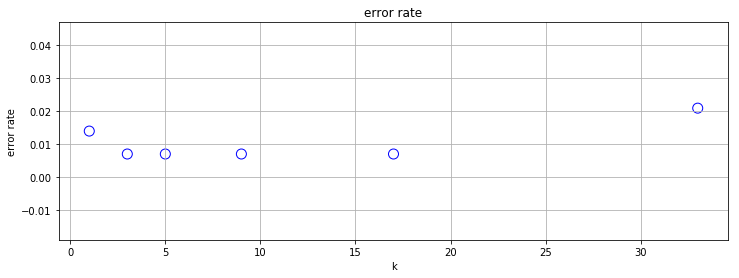

In [15]:
# plot results
plt.figure(figsize=(12,4))

plt.scatter(K,err,s=100,facecolor='None',edgecolors='b')

plt.grid()
plt.ylabel('error rate')
plt.xlabel('k')
plt.title('error rate')

print('errpr rate is minimal for k =',K[np.argmin(err)])

The error rate is minimal with a value of approximately $0.7 \%$ between $k = 3$ and $k = 17$. It increases significantly for $k = 33$, and is also larger for $k=1$. Appearently, taking to many neighbors into account averages out some of the uniqueness of the features, which results in a larger error rate.

## 4 Cross-validation

In [16]:
# define splitting function
def split_folds(data, target, L):
    N = len(data)
    
    # randomly arange indices
    rand_ind = np.random.permutation(N)
    
    # split into L folds
    folds_ind = np.array_split(rand_ind, L)
    
    return [data[i] for i in folds_ind], [target[i] for i in folds_ind]

In [18]:
# define parameter space
L_lst = [2,5,10]
k_lst = [1,15]

# create empty lists for error rate
mean_err_c1 = []
std_err_c1 = []

mean_err_c2 = []
std_err_c2 = []

for i in range(len(L_lst)):
    
    # split data set
    X_folds, y_folds = split_folds(data, target, L_lst[i])
    
    # apply classifier 1
    err = [[[p_err(k_nearest_neighbor(k,X_folds[j],[X_folds[l], y_folds[l]]),y_folds[j]) 
            for l in np.where(range(len(X_folds))!=j)[0]] 
            for j in range(len(X_folds))] 
            for k in k_lst]
    
    # compute mean and std for classifier 1
    mean_err_c1.append(np.mean(err,axis=1))
    std_err_c1.append(np.std(err,axis=1))
    
    # apply classifier 2
    err = []
    for k in k_lst:
        for j in range(len(X_folds)):
            for l in np.where(range(len(X_folds))!=j)[0]:
                # initiate
                classifier = knn2(n_neighbors=k)
                classifier.fit(X_folds[l], y_folds[l])
                err.append(p_err(classifier.predict(X_folds[j]), y_folds[j]))
    
    # compute mean and std for classifier 2
    err = np.array(err).reshape([2,len(X_folds)])
    mean_err_c2.append(np.mean(err,axis=1))
    std_err_c2.append(np.std(err,axis=1))    

# list -> numpy array for better slicing
mean_err_c1 = np.array(mean_err_c1)
std_err_c1 = np.array(std_err_c1)

mean_err_c2 = np.array(mean_err_c2)
std_err_c2 = np.array(std_err_c2)


Text(0.5,0,'L')

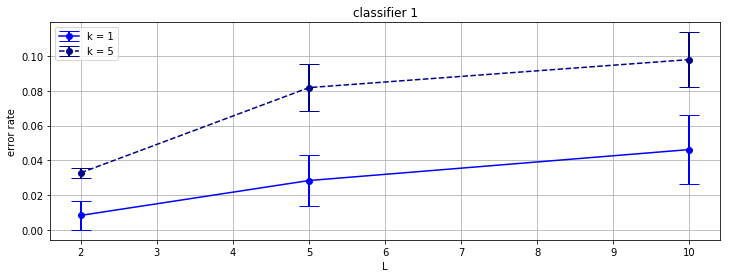

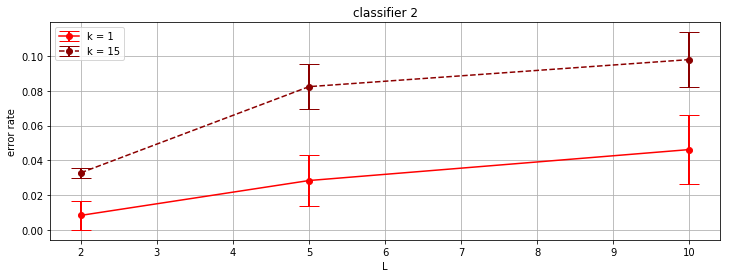

In [19]:
# plot results

# classifier 1
plt.figure(figsize=(12,4))

plt.title('classifier 1')
plt.errorbar(L_lst,mean_err_c1[:,0],yerr=std_err_c1[:,0],color='b',elinewidth=2,capsize=10,fmt='o-', label = 'k = 1')
plt.errorbar(L_lst,mean_err_c1[:,1],yerr=std_err_c1[:,1],color='darkblue',elinewidth=2,capsize=10,fmt='o--', label = 'k = 5')

plt.grid()
plt.legend()
plt.ylabel('error rate')
plt.xlabel('L')

# classifier 2
plt.figure(figsize=(12,4))

plt.title('classifier 2')
plt.errorbar(L_lst,mean_err_c2[:,0],yerr=std_err_c2[:,0],color='r',elinewidth=2,capsize=10,fmt='o-', label = 'k = 1')
plt.errorbar(L_lst,mean_err_c2[:,1],yerr=std_err_c2[:,1],color='darkred',elinewidth=2,capsize=10,fmt='o--', label = 'k = 15')

plt.grid()
plt.legend()
plt.ylabel('error rate')
plt.xlabel('L')

Classifier 1 (this implementation) and classifier 2 (sklearn) both give the same result  as should be expected. The error rates are larger for $k=15$ than for $k=1$. The standard devation of the error rate decreases with increasing $L$.